# XGBClassifier

In [1]:
import some_load_train_evaluate_functions as ml

from xgboost import XGBClassifier

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = '../KG/db.env'

driver = ml.connect_to_neo4j(path)

Connected to database successfully.


### Load Data

In [3]:
# Diabetes data

diabetes_df = ml.get_data_of_disease(driver, 'Diabetes')
diabetes_df

,Respondent_ID,Gender,Age,BMI,25-hydroxyvitamin D2 + D3 [nmol/L],A/G Ratio,Alpha-carotene [umol/L],Alpha-crypotoxanthin [umol/L],Alpha-tocopherol [umol/L],Basophils [%],...,Ferritin [ng/mL],Gamma Glutamyl Transferase [IU/L],Hemoglobin [g/dL],Insulin [pmol/L],LDL-Cholesterol(NIH2) [mmol/L],Lactate Dehydrogenase [IU/L],Transferrin Saturation [%],Transferrin receptor [nmol/L],Triglyceride [mmol/L],Diabetes
0,93703,0,2,17.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,93704,1,2,15.7,74.4,NaN,NaN,NaN,NaN,0.7,...,36.60,NaN,13.1,NaN,NaN,NaN,NaN,30.6,NaN,0
2,93705,0,66,31.7,89.9,1.517241,0.138,0.071,26.006,1.0,...,28.70,21.0,11.9,NaN,NaN,174.0,28.0,39.8,NaN,0
3,93706,1,18,21.5,53.8,1.629630,0.160,0.031,16.765,0.8,...,284.00,16.0,16.3,NaN,NaN,142.0,51.0,34.0,NaN,0
4,93707,1,13,18.1,58.2,1.857143,0.009,0.044,22.756,0.5,...,49.30,9.0,14.5,NaN,NaN,177.0,21.0,34.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8888,102952,0,70,20.0,82.7,1.846154,0.235,0.077,31.347,0.6,...,135.00,18.0,13.4,26.34,1.112,168.0,39.0,29.1,0.881,1
8889,102953,1,42,35.8,49.5,1.142857,0.106,0.080,21.873,0.6,...,120.00,28.0,15.5,NaN,NaN,136.0,20.0,28.6,NaN,0
8890,102954,0,41,26.1,50.5,1.500000,0.117,0.056,26.935,1.4,...,1.99,8.0,6.4,56.94,2.793,123.0,5.0,248.0,0.553,0
8891,102955,0,14,45.6,61.9,1.205882,0.031,0.079,17.856,0.9,...,11.40,16.0,11.4,NaN,NaN,158.0,5.0,57.7,NaN,0


### Training

In [4]:
xg_boost = XGBClassifier()

# Attributes and Labels

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='mean'),
                                                              random_state=42)

# Training

xg_boost.fit(X_train.values, y_train.values)

# Accuracy scores

y_pred = xg_boost.predict(X_val)

print('Training Accuracy: ',ml.accuracy_score(y_train, xg_boost.predict(X_train)))

print('Validation Accuracy: ',ml.accuracy_score(y_val, y_pred))

Training Accuracy:  0.9955018273826258
Validation Accuracy:  0.9960640989597975


## Feature Selection

### Correlation Analysis

In [6]:
pos_corr, neg_corr = ml.get_correlated_features(diabetes_df,'Diabetes',pos=0.0,neg=-0.0)

corr_features = list(pos_corr.keys()[1:]) + list(neg_corr.keys())
corr_features.remove('Respondent_ID')
corr_features_ = list(pos_corr.keys()[1:15]) + list(neg_corr.keys()[:15])
corr_features_.remove('Respondent_ID')

corr_features_

['Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Age',
 'BMI',
 'Blood Urea Nitrogen [mg/dL]',
 'Insulin [pmol/L]',
 'Osmolality [mmol/Kg]',
 'Retinol [umol/L]',
 'Triglyceride [mmol/L]',
 'Alpha-tocopherol [umol/L]',
 'Triglyceride_HDL Ratio',
 'Segmented neutrophils [%]',
 'Neutrophil_Lymphocyte Ratio',
 'C-Reactive Protein [mg/L]',
 'Cobalt [nmol/L]',
 'Respondent ID',
 'Eosinophils [%]',
 'UIBC [umol/L]',
 'Nucleated RBCs',
 'Total Cholesterol [mmol/L]',
 'Cis-beta-carotene [umol/L]',
 'Creatine Phosphokinase [IU/L]',
 'Total Calcium [mg/dL]',
 'Trans-beta-carotene [umol/L]',
 'Alpha-carotene [umol/L]',
 'Total Protein [g/dL]',
 'RBC count [million cells/uL]',
 'Sodium [mmol/L]',
 'Alkaline Phosphatase [IU/L]']

In [7]:
ml.evaluate_feature_set(corr_features, XGBClassifier(), X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.996

Test Accuracy: 0.996

Precision: 1.000

Recall: 0.971

F1-Score: 0.985


### SelectFromModel

In [8]:
sfm_features = ml.select_from_model_features(ml.RandomForestClassifier(),X,y)
sfm_features

['Respondent ID',
 'Age',
 'BMI',
 'Chromium [nmol/L]',
 'Cobalt [nmol/L]',
 'Glycohemoglobin [%]',
 'Blood Urea Nitrogen [mg/dL]',
 'Osmolality [mmol/Kg]',
 'Total Cholesterol [mmol/L]',
 'Fasting Glucose [mmol/L]']

In [9]:
sfm_features = list(sfm_features)

ml.evaluate_feature_set(sfm_features, XGBClassifier(), X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.990

Test Accuracy: 0.991

Precision: 0.998

Recall: 0.934

F1-Score: 0.965


### SelectKBest

In [10]:
k_best_features = ml.select_k_best(X, y, n=30)
k_best_features[:30]

['Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Age',
 'BMI',
 'Blood Urea Nitrogen [mg/dL]',
 'Osmolality [mmol/Kg]',
 'Retinol [umol/L]',
 'Lymphocyte [%]',
 'Insulin [pmol/L]',
 'Alpha-tocopherol [umol/L]',
 'Lymphocyte_C-Reactive Protein Ratio',
 'Segmented neutrophils [%]',
 'Neutrophil_Lymphocyte Ratio',
 'Alpha-crypotoxanthin [umol/L]',
 'Albumin [g/dL]',
 'Direct HDL-Cholesterol [mmol/L]',
 'Platelet_WBC Ratio',
 'C-Reactive Protein [mg/L]',
 'Creatinine [mg/dL]',
 'Ferritin [ng/mL]',
 'Chloride [mmol/L]',
 'Red cell distribution width [%]',
 'Triglyceride [mmol/L]',
 'A/G Ratio',
 'Platelet count [1000 cells/uL]',
 'Triglyceride_HDL Ratio',
 'Trans-lycopene [umol/L]',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Total Lycopene [umol/L]',
 'Mean platelet volume [fL]']

In [11]:
ml.evaluate_feature_set(k_best_features[:30], XGBClassifier(), X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.991

Test Accuracy: 0.992

Precision: 0.991

Recall: 0.948

F1-Score: 0.969


### Recursive Feature Elimination (RFE) 

In [12]:
rfe_features = ml.select_rfe_features(ml.XGBClassifier(),X,y,n=30,step=0.5)
rfe_features[:30]

['Systemic Immune‐inflammation Index (SII)',
 'Beta-cryptoxanthin [umol/L]',
 'Trans-lycopene [umol/L]',
 'C-Reactive Protein [mg/L]',
 'Retinyl stearate [umol/L]',
 'Mean Cell Hgb Conc. [g/dL]',
 'Transferrin receptor [nmol/L]',
 'Alanine Aminotransferase [U/L]',
 'Alpha-crypotoxanthin [umol/L]',
 'Hemoglobin [g/dL]',
 'RBC count [million cells/uL]',
 'Basophils [%]',
 'Lactate Dehydrogenase [IU/L]',
 'Fasting Glucose [mmol/L]',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Uric Acid [mg/dL]',
 'Total Cholesterol [mmol/L]',
 'Blood Urea Nitrogen [mg/dL]',
 'Insulin [pmol/L]',
 'Retinyl palmitate [umol/L]',
 'Lymphocyte_Monocyte Ratio',
 'Age',
 'Non_HDL Ratio',
 'BMI',
 'Chromium [nmol/L]',
 'LDL_HDL Ratio',
 'Glycohemoglobin [%]',
 'Iron frozen [umol/L]',
 'Triglyceride_HDL Ratio',
 'LDL-Cholesterol(NIH2) [mmol/L]']

In [13]:
ml.evaluate_feature_set(rfe_features[:30], XGBClassifier(), X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.992

Test Accuracy: 0.992

Precision: 0.994

Recall: 0.950

F1-Score: 0.971


### Lasso Regularization

In [14]:
l1_selected_features = ml.log_reg_lasso_select(X_train, y_train)
l1_selected_features[:30]

['Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Age',
 'Gender',
 'BMI',
 'Retinol [umol/L]',
 'Total Cholesterol [mmol/L]',
 'Non_HDL Ratio',
 'Alkaline Phosphatase [IU/L]',
 'Insulin [pmol/L]',
 'Osmolality [mmol/Kg]',
 'Vitamin C [umol/L]',
 'Blood lead [umol/L]',
 'Transferrin receptor [nmol/L]',
 'Gamma Glutamyl Transferase [IU/L]',
 'Mean Cell Hgb Conc. [g/dL]',
 'Aspartate Aminotransferase [U/L]',
 'Transferrin Saturation [%]',
 'Creatine Phosphokinase [IU/L]',
 'LDL-Cholesterol(NIH2) [mmol/L]',
 'Lactate Dehydrogenase [IU/L]',
 'Creatinine [mg/dL]',
 'White blood cell count [1000 cells/uL]',
 'Platelet_Lymphocyte Ratio',
 'Total Cholestrol_HDL Ratio',
 'Retinyl palmitate [umol/L]',
 'Uric Acid [mg/dL]',
 'Bicarbonate [mmol/L]',
 'Direct HDL-Cholesterol [mmol/L]',
 'Sodium [mmol/L]']

In [15]:
ml.evaluate_feature_set(l1_selected_features[:30], XGBClassifier(), X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.992

Test Accuracy: 0.992

Precision: 0.996

Recall: 0.948

F1-Score: 0.971


### Relief F

In [16]:
relieff_features = ml.relief_feature_select(30,X,y)

In [17]:
relieff_features[:30]

['Age',
 'Glycohemoglobin [%]',
 'Respondent ID',
 'BMI',
 'Fasting Glucose [mmol/L]',
 'Segmented neutrophils [%]',
 'Hematocrit [%]',
 'Lymphocyte [%]',
 'Retinol [umol/L]',
 'Hemoglobin [g/dL]',
 'Total Cholesterol [mmol/L]',
 'Neutrophil_Lymphocyte Ratio',
 'Non_HDL Ratio',
 'Osmolality [mmol/Kg]',
 'Total Iron Binding Capacity [umol/L]',
 'Alpha-tocopherol [umol/L]',
 'Blood Urea Nitrogen [mg/dL]',
 'Potassium [mmol/L]',
 'Chloride [mmol/L]',
 'Mean cell volume [fL]',
 'Sodium [mmol/L]',
 'Total Protein [g/dL]',
 'Total Calcium [mg/dL]',
 'Total Cholestrol_HDL Ratio',
 'Gamma-tocopherol [umol/L]',
 'Lactate Dehydrogenase [IU/L]',
 'Phosphorus [mg/dL]',
 'A/G Ratio',
 'Uric Acid [mg/dL]',
 'Mean platelet volume [fL]']

In [18]:
ml.evaluate_feature_set(relieff_features[:30], XGBClassifier(), X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.995

Test Accuracy: 0.996

Precision: 1.000

Recall: 0.971

F1-Score: 0.985


### XGBoost Feature Importances

In [19]:
def get_xgb_features(model, X_train):
    
    xgb_features = ml.pd.DataFrame(model.feature_importances_, index=X_train.columns,
                                             columns=['Importance'])
    xgb_features = xgb_features.sort_values('Importance', ascending=False)
    xgb_features = list(xgb_features.index)
    
    return xgb_features

In [20]:
xgb_features = get_xgb_features(xg_boost, X_train)
xgb_features[:30]

['Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Age',
 'LDL-Cholesterol(NIH2) [mmol/L]',
 'Non_HDL Ratio',
 'RBC count [million cells/uL]',
 'Lymphocyte_Monocyte Ratio',
 'Transferrin receptor [nmol/L]',
 'Trans-lycopene [umol/L]',
 'Retinol [umol/L]',
 'Iron [ug/dL]',
 'Blood Urea Nitrogen [mg/dL]',
 'Neutrophil_Lymphocyte Ratio',
 'Hydroxycotinine [ng/mL]',
 'Bicarbonate [mmol/L]',
 'Transferrin Saturation [%]',
 'Vitamin C [umol/L]',
 'Chloride [mmol/L]',
 'UIBC [umol/L]',
 'BMI',
 'Chromium [nmol/L]',
 'Monocyte [%]',
 'Retinyl stearate [umol/L]',
 'Beta-cryptoxanthin [umol/L]',
 'Platelet_Lymphocyte Ratio',
 'Systemic Immune‐inflammation Index (SII)',
 'Potassium [mmol/L]',
 'Alpha-carotene [umol/L]',
 'A/G Ratio',
 'Mean cell volume [fL]']

In [21]:
ml.evaluate_feature_set(xgb_features, XGBClassifier(), X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.996

Test Accuracy: 0.996

Precision: 1.000

Recall: 0.971

F1-Score: 0.985


### Optimal no. of features

In [22]:
final_features = list(xgb_features) 

Finding optimal no. of features..: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [09:25<00:00,  6.57s/it]



Maximum f1 = 0.7461 for 75 features


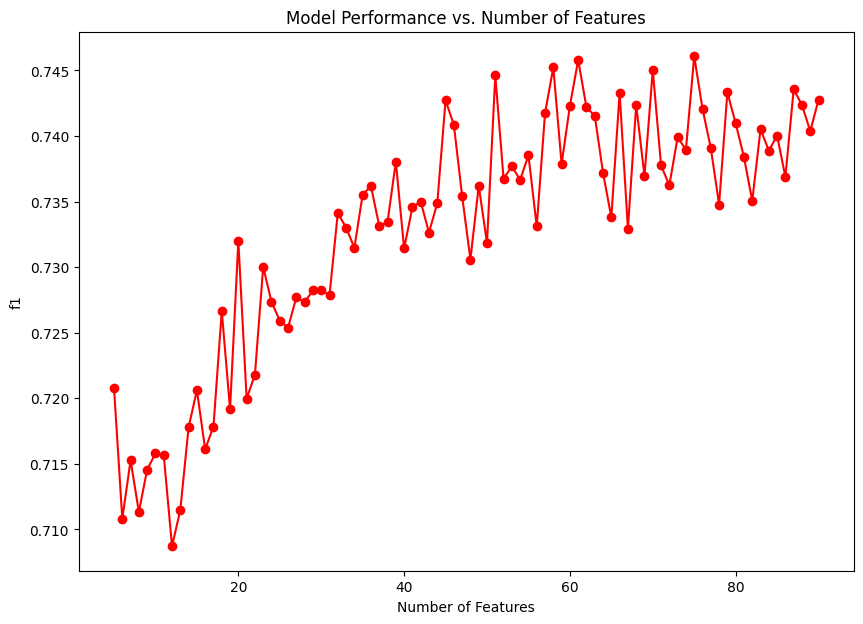

In [24]:
# Optimal no. of features

ml.plot_num_feature_performance(XGBClassifier(device="cuda"),  X, y, final_features, scoring='f1', val=True)

In [25]:
num_features = 75

selected = final_features[:num_features]
selected.append('Diabetes')

diabetes_df = diabetes_df[selected]

In [26]:
# Save feature set
    
with open('../Models/Diabetes/Feature Sets/XG Boost Features.pkl', 'wb') as f:
    ml.pickle.dump(selected, f)

## Preprocessing

### Zero Imputation

In [27]:
# Imputing null values with zeroes

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                        impute = True, scale=True,
                                                        imputer=ml.SimpleImputer(strategy='constant',fill_value=0),
                                                        random_state=42)

In [28]:
xg_boost = XGBClassifier(device='cuda')
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.992

Test Accuracy: 0.993

Precision: 0.991

Recall: 0.955

F1-Score: 0.973


### Mode Imputation

In [29]:
# Imputing with most frequent values

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='most_frequent'),
                                                              random_state=42)

In [30]:
xg_boost = XGBClassifier(device='cuda')
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.992

Test Accuracy: 0.992

Precision: 0.991

Recall: 0.950

F1-Score: 0.970


### Median Imputation

In [34]:
# Imputing with median values

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='median'),
                                                              random_state=42)

In [35]:
xg_boost = XGBClassifier(device='cuda')
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.992

Test Accuracy: 0.992

Precision: 0.994

Recall: 0.948

F1-Score: 0.970


### Mean Imputation

In [36]:
# Splitting and Preprocessing data

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='mean'),
                                                              random_state=42)

In [37]:
xg_boost = XGBClassifier(device='cuda')
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.992

Test Accuracy: 0.992

Precision: 0.991

Recall: 0.948

F1-Score: 0.969


### k-NN Imputation

In [38]:
# Imputing missing values with values from the k-nearest neighbors in the feature space

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.KNNImputer(n_neighbors=20),
                                                              random_state=42)

In [39]:
xg_boost = XGBClassifier(device='cuda')
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.998

Test Accuracy: 0.994

Precision: 0.989

Recall: 0.969

F1-Score: 0.979


### Dropping Null Values

In [40]:
# Drop null values
diabetes_df_na = diabetes_df.dropna()

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df_na, label = 'Diabetes',
                                                              impute = False, scale=True,
                                                              random_state=42)

In [41]:
xg_boost = XGBClassifier(device='cuda')
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000


### Multiple Imputation by Chained Equations (MICE)

In [5]:
# Imputes by looking at data from other columns and trying to estimate the best prediction for each missing value.

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.IterativeImputer(max_iter=20),
                                                              random_state=42)

In [6]:
xg_boost = XGBClassifier(device='cuda')
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.992

Recall: 0.969

F1-Score: 0.980


## Hyperparameter Optimization 

In [44]:
param_grid = {
    
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [1, 1.5, 2, 3],
    
}

### Random Search

In [49]:
rand_best_params, xg_boost_rand = ml.random_search_optimize(XGBClassifier(),param_grid,n_iter=100,cv=5,
                                                               X_train=X_train, y_train=y_train,
                                                               scoring='accuracy', val=True)

In [8]:
rand_best_params

{'subsample': 0.9,
 'reg_lambda': 1.5,
 'reg_alpha': 0,
 'learning_rate': 0.1,
 'gamma': 0.2}

In [14]:
rand_best_params.update({'device': 'cuda'})
rand_best_params

{'subsample': 0.9,
 'reg_lambda': 1.5,
 'reg_alpha': 0,
 'learning_rate': 0.1,
 'gamma': 0.2,
 'device': 'cuda'}

In [51]:
ml.evaluate_model_metrics(xg_boost_rand,X_train,y_train,X_val,y_val)


Train Accuracy: 0.990

Test Accuracy: 0.990

Precision: 0.991

Recall: 0.938

F1-Score: 0.964


### Optuna

In [52]:
def objective(trial):

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
    }

    if params['booster'] == 'gbtree' or params['booster'] == 'dart':
        params['subsample'] = trial.suggest_uniform('subsample', 0.1, 1.0)
        params['colsample_bytree'] = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)

    model = XGBClassifier(**params)
    
    model.fit(X_train.values, y_train.values)
    y_pred = model.predict(X_test.values)

    accuracy = ml.accuracy_score(y_test.values, y_pred)

    return accuracy

In [53]:
best_trial , xg_boost_opt = ml.optuna_optimize(objective, XGBClassifier, n_trials=150)

In [10]:
best_trial

{'booster': 'dart',
 'lambda': 2.9031190755560928e-08,
 'alpha': 7.229744977210442e-05,
 'max_depth': 8,
 'eta': 0.41819998175350637,
 'gamma': 4.6824952525634463e-08,
 'grow_policy': 'depthwise',
 'subsample': 0.6230443706871261,
 'colsample_bytree': 0.9858046013024417}

In [13]:
best_trial.update({'device': 'cuda'})
best_trial

{'booster': 'dart',
 'lambda': 2.9031190755560928e-08,
 'alpha': 7.229744977210442e-05,
 'max_depth': 8,
 'eta': 0.41819998175350637,
 'gamma': 4.6824952525634463e-08,
 'grow_policy': 'depthwise',
 'subsample': 0.6230443706871261,
 'colsample_bytree': 0.9858046013024417,
 'device': 'cuda'}

In [57]:
xg_boost_opt.device = 'cuda'
xg_boost_opt.fit(X_train.values,y_train.values)

ml.evaluate_model_metrics(xg_boost_opt,X_train,y_train,X_val,y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.992

Recall: 0.971

F1-Score: 0.981


## Evaluation on Test Set


Train Accuracy: 0.995

Test Accuracy: 0.994

Precision: 0.987

Recall: 0.970

F1-Score: 0.979

Confusion Matrix:

[[3080    6]
 [  14  457]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      3086
     Class 1       0.99      0.97      0.98       471

    accuracy                           0.99      3557
   macro avg       0.99      0.98      0.99      3557
weighted avg       0.99      0.99      0.99      3557


ROC-AUC Curve:


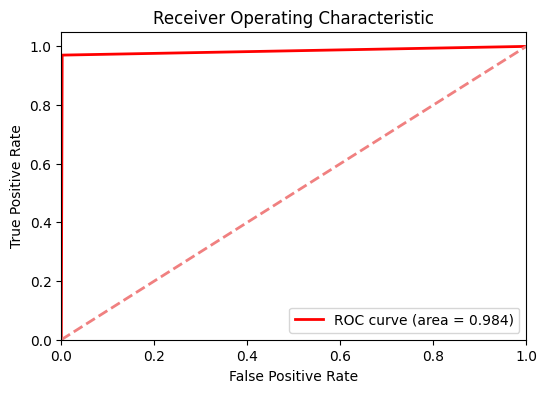

In [58]:
# After evaluating on the validation set, we evaluate and finalize on the test set

ml.evaluate_model_metrics(xg_boost_opt, X_train, y_train, X_test, y_test, verbose=6)

## Cross Validation

### K-fold

In [11]:
ml.k_cross_validate(XGBClassifier(device='cuda'),X_train.values, y_train,cv=10,scoring='accuracy')


accuracy scores: [0.92696629 0.92696629 0.93398876 0.93539326 0.93670886 0.91420534
 0.92686357 0.93248945 0.94655415 0.94374121]

Mean accuracy score:  0.9323877194645933

Standard deviation:  0.008830443876794122


In [15]:
ml.k_cross_validate(XGBClassifier(**rand_best_params),X_train.values, y_train,cv=10,scoring='accuracy')


accuracy scores: [0.93258427 0.92977528 0.92837079 0.93820225 0.93389592 0.91420534
 0.93389592 0.93670886 0.94655415 0.94796062]

Mean accuracy score:  0.9342153400022125

Standard deviation:  0.009057755068648412


In [16]:
ml.k_cross_validate(XGBClassifier(**best_trial),X_train.values, y_train,cv=10,scoring='accuracy')


accuracy scores: [0.92134831 0.92134831 0.92275281 0.92837079 0.93248945 0.91983122
 0.92123769 0.93108298 0.93670886 0.9395218 ]

Mean accuracy score:  0.9274692235970861

Standard deviation:  0.006812172074773503


### Stratified K-fold

In [17]:
ml.stratified_k_cross_validate(XGBClassifier(device='cuda'),X_train,y_train,n_splits=10)


Average Accuracy: 0.9336529496357402

Average Precision: 0.81597233764576

Average Recall: 0.6533881578947368

Average F1-Score: 0.7249262159117882


In [18]:
ml.stratified_k_cross_validate(XGBClassifier(**rand_best_params),X_train,y_train,n_splits=10)


Average Accuracy: 0.9337945843012688

Average Precision: 0.8222510883005694

Average Recall: 0.646140350877193

Average F1-Score: 0.723271758310912


In [19]:
ml.stratified_k_cross_validate(XGBClassifier(**best_trial),X_train,y_train,n_splits=10)


Average Accuracy: 0.9263460231672436

Average Precision: 0.7756062357257669

Average Recall: 0.6367105263157895

Average F1-Score: 0.6987791612054757


### Save Model

In [23]:
# Saving the model

final_xgb_estimator = XGBClassifier(device='cuda')
final_xgb_estimator.fit(X_train.values, y_train)

ml.save_model(final_xgb_estimator, "../Models/Diabetes/XGBoost_Classifier.pkl")

Overwrite File? [y/n]: y
Saved Model


## Prediction

In [24]:
# Predicting on perturbed values

ml.predict_on_modified_instance(final_xgb_estimator, X_test.iloc[0], y_test.iloc[0], 0.6)

Instance:
 [ 0.45453676  0.26023542  1.68064713  0.1809038   0.03595777 -0.41758194
 -0.61630718  0.01149575  0.83220339  0.26922518 -0.40605796  1.75872879
  0.5825039  -0.31325017  1.26022198 -0.40938003 -0.07401896 -1.34250963
  0.1457841   0.04292062 -0.25468048 -0.23540004 -0.18271512 -0.84510652
 -0.10090466  0.96651919  1.74428071  0.07034973 -0.53177297  0.40961473
  0.02661802 -0.27790386 -1.44778414 -0.92992156  0.42396292  0.34307552
 -1.31877588 -0.0695717   1.602578   -0.25491555  0.50239896 -1.13745104
  0.917206    0.64266756 -0.49444572 -1.06004946  0.5237883   0.43071653
 -0.07574803 -0.31464574 -0.95375019 -0.08997438  1.56788457  0.93278433
 -0.48030594 -0.01485563 -0.31009844  0.05273091 -1.09837545  1.39699032
 -0.37819214  0.73617398 -1.0433605   1.11388503 -0.04956491 -0.43319113
  2.99047135  0.6588992   1.76562719  0.60458152  0.6752223   1.16097056
  1.30936202 -0.5718267  -0.37768595]

Expected Class:  0.0

 Modified Instance:
 [ 4.54536757e-01  2.46145302e-0

In [25]:
ml.predict_on_modified_instance(final_xgb_estimator, X_test.iloc[10], y_test.iloc[10], 1.5)

Instance:
 [ 1.62125434  1.51632644  1.72059969  1.17916166  1.75267508  0.21349578
 -0.07042027  0.37166902  3.66742601  1.82674152 -0.43920078  3.04908385
 -0.53551877 -0.31337311  0.28008272 -0.51037391  0.90756182 -1.34250963
  0.32906391  0.91693503 -0.25468048  0.10593641  0.46434915 -0.48579269
 -1.48060016 -1.01900929  0.75053891 -0.26974774 -0.26413262  0.9210946
  0.41713345  1.95903888  0.39539437  0.58962852  0.2354109  -0.31416356
 -0.65424637  1.87917653 -0.09208476 -0.30194794  0.87616507  0.21670302
 -0.42606869 -1.42425956  0.40139562  1.98938315 -0.40983944  0.40081023
  0.10597857 -0.51866645 -1.34361542  0.92090302  3.10649088  0.26025101
  0.8772802   3.61751987  1.26796914  0.05273091 -0.92035338  3.6294411
 -0.43355435 -0.09910515  0.4119524  -0.18308696  0.40816967 -0.02791887
  0.91772262  2.03652809  1.76562719  0.24102482 -1.82034453  0.31964053
 -0.19395509  0.67550686 -0.38008452]

Expected Class:  1.0

 Modified Instance:
 [ 1.62125434  1.26766094  1.79687